Boucle globale de lecture de vidéo


state= 0
    img_calibration
    obstacle detection
    start and goal
    global_nav
    
state = 1
    img_calibration
    detect Thymio
    astolfi ou local nav
    
    

In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

#vérifier d'avoir installer pyserial

Node eb16048f-962c-44b2-9651-cc3b67bca83b

# Initialisation

In [2]:
#check each import if it's really necessary
import cv2 
import time
import numpy as np
from PIL import Image 
import math
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

#import from global control
#import from glocal + control
import pyvisgraph as vg
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, Point, LineString
import time

In [3]:
import Vision as vis
import Global as glob
import control as ctrl
import local_nav as local

# fonction et classe filtering
from kalman_step_astolfi import kalman_step_complet
from EKF_astolfi import ExtendedKalmanFilterAstolfi

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 334.19it/s]



Visibility graph points:  [[Point(414.32, 255.63), Point(416.69, 393.62), Point(560.68, 391.37), Point(558.31, 253.38)], [Point(133.15, 201.00), Point(127.87, 385.98), Point(288.23, 389.99), Point(291.75, 205.02)], [Point(350.40, -15.66), Point(238.92, 70.27), Point(332.60, 177.66), Point(444.08, 91.73)], [Point(-33.00, -19.00), Point(-33.00, 136.00), Point(153.92, 136.00), Point(162.19, -19.00)]] 

Shortest path distance: 614.269244296845 

0    POLYGON ((414.315 255.631, 416.694 393.619, 56...
1    POLYGON ((133.155 201.004, 127.870 385.984, 28...
2    POLYGON ((350.396 -15.663, 238.918 70.267, 332...
3    POLYGON ((-33.000 -19.000, -33.000 136.000, 15...
0                               POINT (46.877 339.175)
1                              POINT (133.155 201.004)
2                              POINT (332.604 177.663)
3                               POINT (548.500 50.500)
dtype: geometry 

path  0     POINT (46.877 339.175)
1    POINT (133.155 201.004)
2    POINT (332.604 177.663)
3 

dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
failure in identifying corners
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, update
dans test de distance
bonne distance detectee, upda

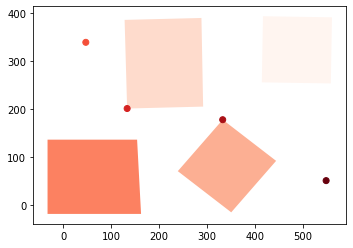

In [4]:
#Open camera
cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
frame=vis.takePicture(cap)

#global variables 
state=0 #state of the global FSM
switch_next=0  #FSM for Astolfi
path_iter=1  #next step in the path list = being the starting position
obst = [0,0,0,0,0]   # measurements from front prox sensors
y = [0,0]          # powers given to motor wheels


#variables definition for the main loop


#init des variables Kalman, et visu de la trace
KF = ExtendedKalmanFilterAstolfi()
KF.set_time_stamp(time.time())

sensor_package = []
kalman_pos = []

coordThym = []
coordKalm = []

while (cap.isOpened()):
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
 
    if(state==0):
        corner_coord=vis.find_corners(img)
        final=vis.img_calibration(img, corner_coord)
        init=vis.initialisation(final)
        path=glob.global_pathplanning(init[0],init[1],init[2])
        
        #rajouter angle initial
        init_pos=[init[0][0],init[0][1]]
        angle_kalman=init[3]
        KF.init_state_vector(init_pos[0],init_pos[1],angle_kalman,0,0,0,0,0)
        
        state=1
        
    if (state==1):
        final=vis.img_calibration(img, corner_coord)
        pos_thym=vis.detectThymio(final)[0]
        angle_thym=vis.directionThymio(final)
        
        vit_roue_droite = ctrl.read_motors_speed(node,client)[1]
        vit_roue_gauche = ctrl.read_motors_speed(node,client)[0]
        sensor_package = [pos_thym[0], pos_thym[1], angle_thym, vit_roue_droite, vit_roue_gauche]
        E = kalman_step_complet(sensor_package,KF)
        kalman_pos = [E[0], E[1]]
        kalman_pos = np.squeeze(np.asarray(kalman_pos))
        angle_kalman=E[2]
        angle_kalman = np.squeeze(np.asarray(angle_kalman[0]))
        
        switch_next=ctrl.astolfi(kalman_pos,path[path_iter],angle_kalman,node)
        
        #local avoidance
        # get the proximity sensors values and obstacle update
        prox_horizontal = ctrl.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        # update the state between state 1 and state 2
        state = local.update_state(state,obst,client) 
        
        if(switch_next==1):
            path_iter=path_iter+1
            print("path iter ",path_iter)
            if(path_iter==len(path)):
                ctrl.stopmotors(node)
                print("finish")
                state=3
        
    if(state==2):
        print("debut du local nav --------------------------------")
        y_memory = ctrl.read_motors_speed(node,client)
        y = local.local_nav(prox_horizontal,y_memory)
        ctrl.set_motors(y[0],y[1],node)
        
        # get the proximity sensors values and obstacle update
        prox_horizontal = ctrl.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        # update the state between state 1 and state 2
        state = local.update_state(state,obst,client)
        if state==1:
            print("fin du local nav --------------------------------")
            ret, frame = cap.read()
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            final=vis.img_calibration(img, corner_coord)
            pos_thym=vis.detectThymio(final)[0]
            angle_thym=vis.directionThymio(final)
            KF.init_state_vector(pos_thym[0],pos_thym[1],angle_thym,0,0,0,0,0)
            print("angle dans state vector: ", KF.current_estimate_state()[2])
            print("angle detecte par camera: ", angle_thym)
            

    if state==3:
        break
    
    vis.printGlobalPath(path, final)
    vis.printThymio(final,kalman_pos,coordKalm)
    final = cv2.cvtColor(final, cv2.COLOR_RGB2BGR)
    cv2.imshow("results", final)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()
#output.release()
#cv2.destroyAllWindows()

In [ ]:
#pour le test utilise une image mais en vrai relier à la caméra et temps réel

cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)

for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()


#img_final= cv2.flip(img_final, 0)
img_final2 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
corner_coord=vis.find_corners(img_final2)
img=vis.img_calibration(img_final2,corner_coord)
#cv2.imwrite('warpped.png', zzz)
plt.figure()
plt.imshow(img)
plt.show()



In [5]:
#obstacle detection
polygons=vis.obstacle_detection(img)
#Start and goal detection
start=vis.detectCircle(img,'start')
goal=vis.detectCircle(img,'goal')

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 334.22it/s]


Visibility graph points:  [[Point(426.46, 245.51), Point(410.94, 371.94), Point(543.94, 386.48), Point(561.68, 260.07)], [Point(136.34, 205.56), Point(134.67, 380.55), Point(282.33, 382.44), Point(285.66, 207.45)], [Point(349.66, -8.38), Point(244.24, 71.22), Point(333.86, 169.38), Point(437.14, 89.77)], [Point(-27.47, -15.32), Point(-25.54, 131.32), Point(149.18, 129.69), Point(156.93, -13.67)]] 

Shortest path distance: 556.7991238591716 

0    POLYGON ((426.464 245.509, 410.938 371.936, 54...
1    POLYGON ((136.336 205.558, 134.669 380.550, 28...
2    POLYGON ((349.659 -8.375, 244.244 71.223, 333....
3    POLYGON ((-27.468 -15.318, -25.538 131.324, 14...
0                                  POINT (0.000 0.000)
1                              POINT (156.925 -13.672)
2                               POINT (349.659 -8.375)
3                               POINT (548.000 49.000)
dtype: geometry 

path  0        POINT (0.000 0.000)
1    POINT (156.925 -13.672)
2     POINT (349.659 -8.375)
3 

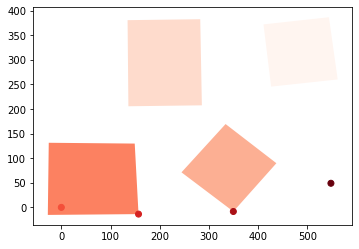

In [6]:
#plot the visibility graph

#a voir si on le met dedans
margin = 35
path=glob.global_pathplanning(start,goal,polygons,margin)


# Control and navigation loop

In [ ]:
#cap=cv2.VideoCapture(0)

In [ ]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)

for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    
#frame=vis.img_calibration(frame)
    
plt.figure()
plt.imshow(frame)
plt.show()

In [ ]:
#img_final = cv2.imread(frame)
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#img= cv2.flip(img, 0)
final=vis.img_calibration(img)
plt.figure()
plt.imshow(final)
plt.show()

In [4]:
def initialisation(pic):
    #obstacle detection
    polygons=vis.obstacle_detection(pic)
    #Start and goal detection
    pos_start=vis.detectThymio(final)[0]
    angle_start=vis.directionThymio(final)
    #start=vis.detectCircle(pic,'start')
    goal=vis.detectCircle(pic,'goal')
    init=[pos_start,goal,polygons,angle_start]
    return init



In [5]:
def printThymio(posThym, coordThym):
    coordThym.append((round(pos_thym[0]),round(pos_thym[1]))) #pos_thym = [x,y]
    for i in range(0,len(coordThym)):
        cv2.circle(final,(int(coordThym[i][0]),int(coordThym[i][1])), int(3), (0,255,255), 2)

In [6]:
def printThymioKalm(posThym, coordThym):    #la couleur de la trace change
    coordThym.append((round(posThym[0]),round(posThym[1]))) #pos_thym = [x,y]
    for i in range(0,len(coordThym)):
        cv2.circle(final,(int(coordThym[i][0]),int(coordThym[i][1])), int(3), (0,0,255), 2)

In [7]:
#convertir frame to real => mm/s vitesse et position


#coefficients for the Astolfi controller (distances in millimeter)
r=22
l=48 
kp=25  #2 #>0
ka=50  #must be > kp
kb=-0.0001 #<0

#coeff_commtoreal=0,38

#astolfi return to iterate on the next goal from the path list

def astolfi(actual_pos, goal_pos, actual_angle, node):
    #déplacer les variables à l'extérieur dans control
    switch_next=0
    thresh_close2=10
    thresh_close1=75
    comm_sat_min=100
    comm_sat_max=250
    
    delta=np.subtract(goal_pos,actual_pos)
    pho=np.sqrt(np.sum(np.square(delta)))
    alpha=-actual_angle + np.arctan2(-delta[1],delta[0])
    beta=-actual_angle-alpha
    v=kp*pho
    if(pho<thresh_close1):
        v=comm_sat_min*r
    if(pho<thresh_close2):
        v=0
        switch_next=1      
    omega=ka*alpha+kb*beta
    right_speed=(l*omega+v)/r
    left_speed=(v-l*omega)/r
    left_speed=int(left_speed)
    right_speed=int(right_speed)
    ctrl.set_motors(left_speed, right_speed, node)
    return switch_next

In [8]:
def printGlobalPath(path, img):
    lineThickness = 3
    for i in range(0,len(path)-1):
        cv2.line(final, (round(path[i][0]), round(path[i][1])),(round(path[i+1][0]), round(path[i+1][1])), (0,255,0), lineThickness)

In [1]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
#frame_size = (int(cap.get(3)),int(cap.get(4)))
#output = cv2.VideoWriter('vid.mp4',cv2.VideoWriter_fourcc(*'XVID'),20,frame_size)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

#cap.release()
#plt.figure()
#plt.imshow(frame)
#plt.show()

#time.sleep(1)
state=0
margin = 40
switch_next=0
path_iter=1
obst = [0,0,0,0,0]   # measurements from front prox sensors
obstThrL = 2500      # low obstacle threshold to switch state 3->2
obstThrL2 = 3000
obstThrH = 3700      # high obstacle threshold to switch state 2->3  #max 4000
y = [0,0]          # powers given to motor wheels

#init des variables Kalman, et visu de la trace
KF = ExtendedKalmanFilterAstolfi()
KF.set_time_stamp(time.time())

sensor_package = []
kalman_pos = []

coordThym = []
coordKalm = []

while (cap.isOpened()):
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
 
    if(state==0):
        corner_coord=vis.find_corners(img)
        final=vis.img_calibration(img, corner_coord)
        init=initialisation(final)
        path=glob.global_pathplanning(init[0],init[1],init[2],margin)
        
        #rajouter angle initial
        init_pos=[init[0][0],init[0][1]]
        angle_kalman=init[3]
        KF.init_state_vector(init_pos[0],init_pos[1],angle_kalman,0,0,0,0,0)
        
        state=2
        
    if (state==2):
        final=vis.img_calibration(img, corner_coord)
        pos_thym=vis.detectThymio(final)[0]
        angle_thym=vis.directionThymio(final)
        
        vit_roue_droite = ctrl.read_motors_speed(node,client)[1]
        vit_roue_gauche = ctrl.read_motors_speed(node,client)[0]
        sensor_package = [pos_thym[0], pos_thym[1], angle_thym, vit_roue_droite, vit_roue_gauche]
        
        #condition de saut d'angle
      #  if (bool(angle_thym)):
     #       if ( abs(angle_thym-angle_kalman)> 0.4 ):
      #          print("Trop grande différence d'angles détectée")
      #  sensor_package=[None,None,None,vit_roue_droite,vit_roue_gauche]
      #      else:
      #          print("Difference d'angles correcte")
        
        E = kalman_step_complet(sensor_package,KF)
        kalman_pos = [E[0], E[1]]
        kalman_pos = np.squeeze(np.asarray(kalman_pos))
        angle_kalman=E[2]
        angle_kalman = np.squeeze(np.asarray(angle_kalman[0]))
        
        switch_next=astolfi(kalman_pos,path[path_iter],angle_kalman,node)
        
        #local avoidance
        # get the proximity sensors values and obstacle update
        prox_horizontal = ctrl.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        # update the state between state 2 and state 3
        state = local.update_state2(state,obstThrL,obstThrH, obst,client) 
        
        if(switch_next==1):
            path_iter=path_iter+1
            print("path iter ",path_iter)
            if(path_iter==len(path)):
                ctrl.stopmotors(node)
                print("finish")
                state=4
        
    if(state==3):
        print("debut du local nav --------------------------------")
        y_memory = ctrl.read_motors_speed(node,client)
        y = local.local_nav(prox_horizontal,y_memory)
        ctrl.set_motors(y[0],y[1],node)
        
        # get the proximity sensors values and obstacle update
        prox_horizontal = ctrl.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        # update the state between state 2 and state 3
        state = local.update_state2(state,obstThrL,obstThrH, obst,client)
        if state==2:
            print("fin du local nav --------------------------------")
            ret, frame = cap.read()
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            final=vis.img_calibration(img, corner_coord)
            pos_thym=vis.detectThymio(final)[0]
            angle_thym=vis.directionThymio(final)
            KF.init_state_vector(pos_thym[0],pos_thym[1],angle_thym,0,0,0,0,0)
            print("angle dans state vector: ", KF.current_estimate_state()[2])
            print("angle detecte par camera: ", angle_thym)
            

    if state==4:
        break
    
    vis.printGlobalPath(path, final)
    #printThymio(pos_thym, coordThym)
    printThymioKalm(kalman_pos,coordKalm)
    final = cv2.cvtColor(final, cv2.COLOR_RGB2BGR)
    cv2.imshow("results", final)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()
#output.release()
#cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [5]:
ctrl.stopmotors(node)

In [ ]:
def detectThymio(imgRGB):
    pts=[]
    #p1 is the big circle and p2 the little
    p1=[]
    p2=[]
    lower=np.array([10,30,30])
    upper=np.array([40,255,255])
    nb_iterations=1
    img_hsv = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, lower, upper)
    img_hsv = cv2.blur(img_hsv,(7,7))
    mask = cv2.erode(mask, None, iterations = nb_iterations)
    mask = cv2.dilate(mask, None, iterations = nb_iterations)
    elements,_ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(len(elements))
    if len(elements) > 0:
        #sorting the detected contours by descending area size
        elements.sort(key=cv2.contourArea, reverse=True)
        #finding big circle
        c=elements[0]
        ((x,y),rayon) = cv2.minEnclosingCircle(c)
        #finding little circle
        c2=elements[1]
        ((x2,y2),rayon2) = cv2.minEnclosingCircle(c2)
        p1=[x,y]
        p2=[x2,y2]
        pts=[p1,p2]
    return pts

#print(detectThymio(final))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
corner_coord=vis.find_corners(frame)
final=vis.img_calibration(frame, corner_coord)
print(detectThymio(final)[0])

In [ ]:
print(init)

In [ ]:
# Navigation initialisation
checkp=1           # goal checkpoint
actual_angle=0     # angle to xy axis
y = [0,0]          # powers given to motor wheels

# FSM initialisation
state = 2          # States FSM 0=global nav, 1=local nav
obst = [0,0,0,0,0]   # measurements from front prox sensors
obstThrL = 2500      # low obstacle threshold to switch state 3->2
obstThrL2 = 3000
obstThrH = 3500      # high obstacle threshold to switch state 2->3 

def update_state(state,obstThrL,obstThrH, obst):
    if state == 2: 
        # switch from goal tracking to obst avoidance if obstacle detected
        if (obst[2] > obstThrH):
            state = 3
            print("change state to local")
        elif (obst[1] > obstThrH):
            state = 3
            print("change state to local")
        elif (obst[3] > obstThrH):
            state = 3
            print("change state to local")
        elif (obst[0] > obstThrH):
            state = 3
            print("change state to local")
        elif (obst[4] > obstThrH):
            state = 3
            print("change state to local")
    elif state == 3:
        if obst[2] < obstThrL:
            if obst[1] < obstThrL:
                if obst[3] < obstThrL:
                    if obst[0] < obstThrL:
                        if obst[4] < obstThrL:
                            # switch from obst avoidance to goal tracking if obstacle got unseen
                            state = 2
                            print("change state to global")
    return state

while True:
    
    # get the proximity sensors values and obstacle update
    prox_horizontal = ctrl.read_prox_sensors(node,client)
    obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
    
    # update the state and speed motors values
    state = update_state(state,obstThrL,obstThrH, obst)
    y = ctrl.read_motors_speed(node,client)
    
    print("state", state)

    if state == 2:
        
        """
        # With positon estimation when vision and/or kalman ready
        
        actual,angle = getting_vis()
        pred_pos,pred_angle = kalman(actual, angle)
        
        actual_pos=pred_pos
        actual_angle=pred_angle
        
        if actual_pos == checkpoints[checkp]: # other option: if (actual_pos - checkpoints[checkp]) < error
            checkp=checkp+1
        goal_pos=checkpoints[checkp]
        
        y = ctrl.astolfi2(actual_pos, goal_pos, actual_angle, node)
        
        """
        y = [100,100]
        ctrl.set_motors(y[0],y[1],node)

    elif state == 3:
        print("obstacles values", obst)
        y = local.local_nav(prox_horizontal,y)
        print("y ",y)
        ctrl.set_motors(y[0],y[1],node)

ctrl.stopmotors(node)

In [10]:
ctrl.stopmotors(node)